In [15]:
import pandas as pd

data = pd.read_csv('../../data/Raw-GPS-data-Kandy-Buses/MAIN/OUTPUTS/merged_segments_1000M.csv')

In [16]:
data = data.dropna()

In [17]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def elbow_method(result,clustering_features):
  # eg :- clustering_features = ['speed_mean', 'speed_variance']
  X = result[clustering_features]

  # Standardize the data (important for K-Means)
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Initialize lists to store inertia values for different k
  inertia_values = []

  # Determine a range of k values to test (e.g., from 1 to 10 clusters)
  k_values = range(1, 11)

  # Calculate inertia for each k value
  for k in k_values:
      kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
      kmeans.fit(X_scaled)
      inertia_values.append(kmeans.inertia_)

  # Plot the elbow graph
  plt.plot(k_values, inertia_values, marker='o', linestyle='-')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.grid(True)
  plt.show()

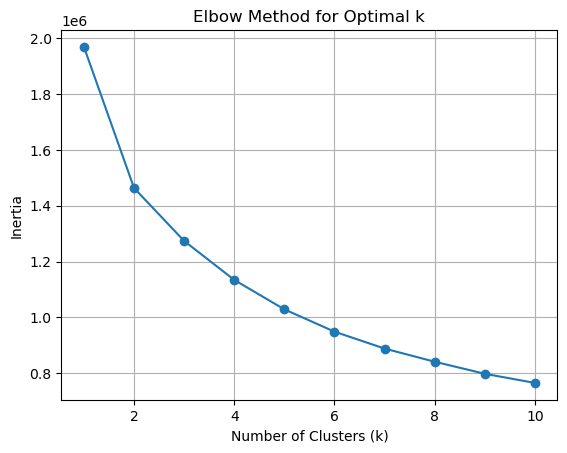

In [18]:
elbow_method(data,['speed_mean', 'speed_std', 'ele_X_speed_n', 'ele_X_speed_p', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc'])

K means

In [19]:
no_pca_components = 4
no_clusters = 3

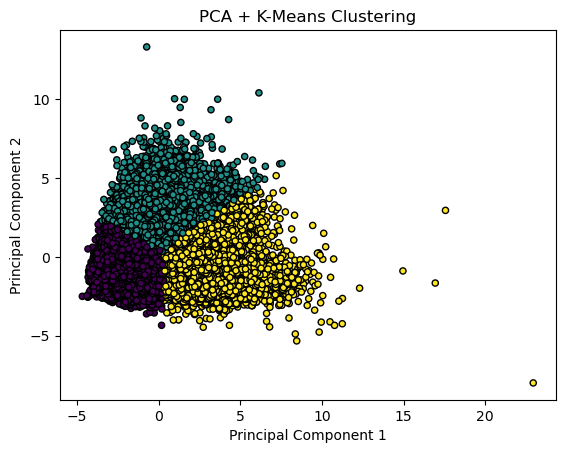

In [20]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = data[['speed_mean', 'speed_std', 'ele_X_speed_n', 'ele_X_speed_p', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc']]


# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=no_pca_components)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Perform K-Means clustering
k = no_clusters  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)

# Fit K-Means on the principal components
principal_df['cluster'] = kmeans.fit_predict(principal_components)

# Plot the clusters in the reduced space
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=principal_df['cluster'], cmap='viridis', marker='o', s=20, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Assuming 'data' is your DataFrame
# data.to_csv('kmeans_clusters.csv', index=False)

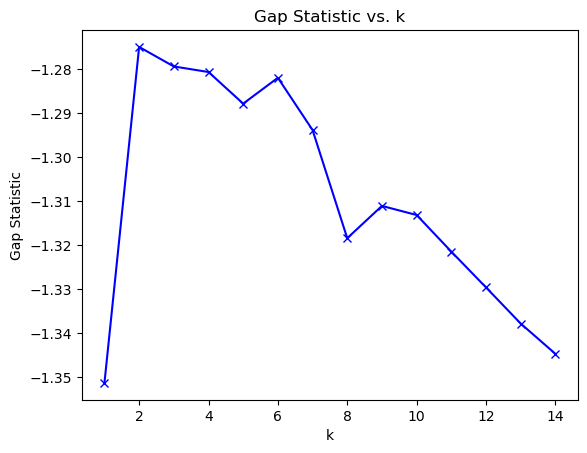

Optimal k: 2


In [21]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def optimalK(data, nrefs=3, maxClusters=10):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data (ndarray): Numpy array of data points.
        nrefs (int): Number of reference datasets to create.
        maxClusters (int): Maximum number of clusters to test for.
    Returns:
        (int): Optimal K (number of clusters).
    """
    gaps = np.zeros((maxClusters-1,))
    resultsdf = np.zeros((maxClusters-1, 2))
    
    # Create reference data
    for gap_index, k in enumerate(range(1, maxClusters)):
        refDisps = np.zeros(nrefs)
        
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(n_clusters=k, n_init=10)
            km.fit(randomReference)
            
            refDisp = sum(np.min(cdist(randomReference, km.cluster_centers_, 'euclidean'), axis=1)) / randomReference.shape[0]
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(n_clusters=k, n_init=10)
        km.fit(data)
        
        origDisp = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf[gap_index] = [k, gap]

    # Plot the gaps
    plt.plot(resultsdf[:,0], resultsdf[:,1], 'bx-')
    plt.xlabel('k')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. k')
    plt.show()

    return np.argmax(gaps) + 1  # Plus 1 because index 0 is for 1 cluster

# Example usage:
print("Optimal k:", optimalK(principal_components, nrefs=5, maxClusters=15))


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

# Calculate silhouette score
score_silhouette = silhouette_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

# calculate davies bouldin score
db_index = davies_bouldin_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(principal_df[['PC1', 'PC2', 'PC3', 'PC4']], principal_df['cluster'])

print("Silhouette Score: ", score_silhouette)
print("Davies Bouldin Index: ", db_index)
print("Calinski-Harabasz Index:", ch_index)


Silhouette Score:  0.23573602991876239
Davies Bouldin Index:  1.370617389392424
Calinski-Harabasz Index: 24964.48484470399


In [14]:
eval_clustering = {
    "no_pca_components": no_pca_components,
    "no_of_clusters": no_clusters,
    "explained_variance_ratio": sum(pca.explained_variance_ratio_),
    "silhouette Score": score_silhouette,
    "Davies Bouldin Index": db_index,
    "Calinski-Harabasz Index": ch_index
}
eval_clustering

{'no_pca_components': 4,
 'no_of_clusters': 3,
 'explained_variance_ratio': 0.9105923049888188,
 'silhouette Score': 0.23573602991876239,
 'Davies Bouldin Index': 1.370617389392424,
 'Calinski-Harabasz Index': 24964.48484470399}

PCA

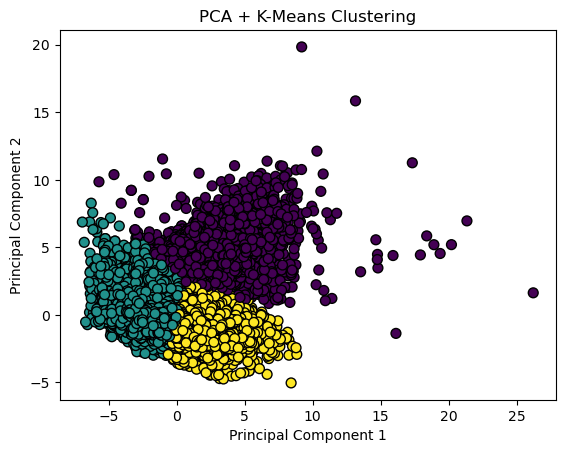

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

data = data.dropna(subset=['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

# Select the features for clustering
X = data[['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n', 'average_acceleration', 'average_deacceleration', 'std_acc_dacc', 'stop_count', 'average_speed', 'max_speed', 'speed_variation']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10,n_clusters=k, random_state=0)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Fit K-Means on the principal components
principal_df['cluster'] = kmeans.fit_predict(principal_components)

data['PC1'] = principal_df['PC1']
data['PC2'] = principal_df['PC2']

# Plot the clusters in the reduced space
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=principal_df['cluster'], cmap='viridis', marker='o', s=50, edgecolors='k')
plt.title('PCA + K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


# Assuming 'data' is your DataFrame
data.to_csv('kmeans_clusters.csv', index=False)
# Add 'deviceid' back to the clustered data
# clustered_data = pd.merge(df_all, result[['deviceid', 'cluster']], on='deviceid')

# Create a scatter plot with annotations
# groups = data['cluster'].unique()

# for group in groups:
#     group_data = data[data['cluster'] == group]
#     plt.scatter(group_data['ele_X_speed_acc_p'], group_data['std_acc_dacc'], label=group)

# # Annotate data points with 'deviceid'
#     # for index, row in group_data.iterrows():
#     #     plt.annotate(row['deviceid'], (row['ele_X_speed_acc_p'], row['ele_X_speed_acc_n']), fontsize=5)

# plt.xlabel('ele_X_speed_acc_p')
# plt.ylabel('std_acc_dacc')
# plt.legend(title='Groups')

# # Show the plot
# plt.show()

In [18]:
cluster_0 = data[data["cluster"]==2]
cluster_0

,segment_starting_time,segment_ending_time,trip_id,deviceid,date,start_terminal,end_terminal,direction,day_of_week,hour_of_day,...,elevation_n,ele_X_speed_acc_p,ele_X_speed_acc_n,average_acceleration,average_deacceleration,std_acc_dacc,stop_count,cluster,PC1,PC2
0,2021-10-16 07:08:31,2021-10-16 07:18:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,-0.048169,5.618765,15.764998,0.603900,-1.230988,1.021837,4,2,3.689867,-2.952610
1,2021-10-16 07:18:31,2021-10-16 07:28:31,1.0,116,2021-10-16,BT02,BT01,2,5,7,...,-0.039004,10.944814,8.906415,0.442037,-0.663055,0.759768,4,2,0.640129,-1.664180
9,2021-10-16 08:43:04,2021-10-16 08:53:04,2.0,116,2021-10-16,BT01,BT02,1,5,8,...,-0.028585,12.076915,5.376656,0.509347,-0.726381,0.802921,6,2,0.022367,-1.188911
22,2021-10-16 13:10:45,2021-10-16 13:20:45,4.0,116,2021-10-16,BT01,BT02,1,5,12,...,-0.032051,12.405068,3.771461,0.523016,-0.792876,0.766072,6,2,0.035236,-0.980281
23,2021-10-16 14:14:36,2021-10-16 14:24:36,5.0,116,2021-10-16,BT02,BT01,2,5,14,...,-0.050555,1.736247,11.189772,0.639767,-0.609552,0.656160,4,2,1.553282,-2.423467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103205,2022-11-01 13:10:36,2022-11-01 13:20:36,17194.0,1377,2022-11-01,BT02,BT01,2,1,13,...,-0.053507,2.459321,12.406693,0.618702,-0.840528,0.761414,7,2,NaN,NaN
103206,2022-11-01 13:20:36,2022-11-01 13:30:36,17194.0,1377,2022-11-01,BT02,BT01,2,1,13,...,-0.031638,9.461470,5.934043,0.557294,-1.004339,0.746320,7,2,NaN,NaN
103215,2022-11-01 15:09:51,2022-11-01 15:19:51,17195.0,1377,2022-11-01,BT01,BT02,1,1,14,...,-0.039912,9.281875,11.275804,0.494730,-0.840790,0.924022,3,2,NaN,NaN
103216,2022-11-01 15:19:51,2022-11-01 15:29:51,17195.0,1377,2022-11-01,BT01,BT02,1,1,14,...,-0.031017,12.777538,3.580043,0.457464,-0.963333,0.856304,2,2,NaN,NaN


In [7]:
print(len(data))

99326


/Users/gimhanranasinghe/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


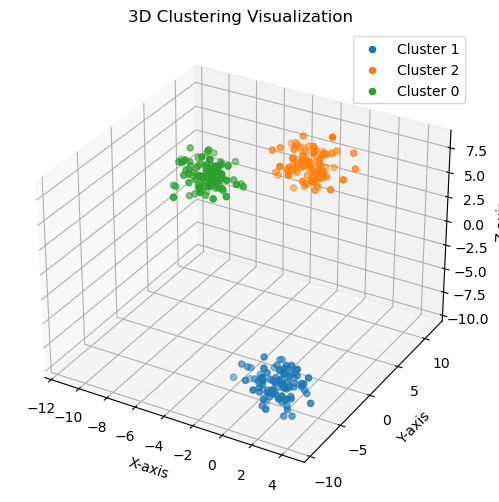

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate synthetic 3D data with three clusters
X, _ = make_blobs(n_samples=300, n_features=3, centers=3, random_state=42, cluster_std=1.0)
df = pd.DataFrame(X, columns=['X', 'Y', 'Z'])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df)

# Visualize the clusters in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster_label]
    ax.scatter(cluster_data['X'], cluster_data['Y'], cluster_data['Z'], label=f'Cluster {cluster_label}')

ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Clustering Visualization')
ax.legend()

plt.show()


3D Clustering Visualization

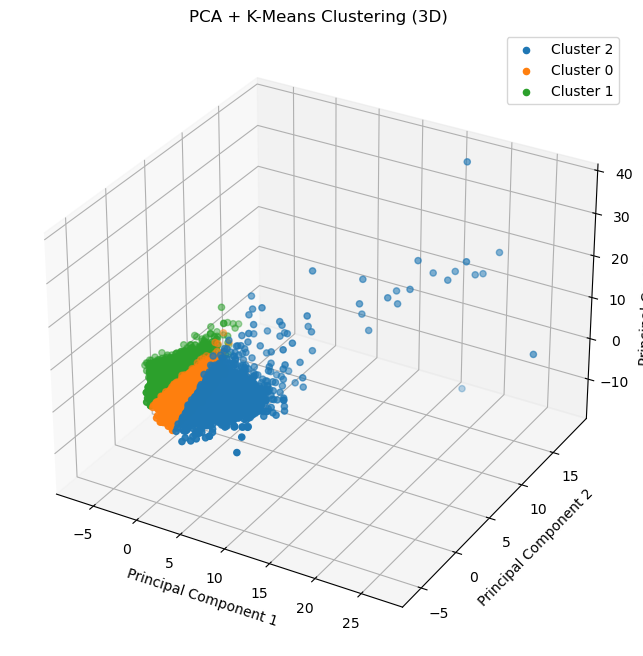

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # Sample data (replace this with your actual data loading)
# data = pd.DataFrame(np.random.rand(100, 11), columns=['elevation_p', 'elevation_n', 'ele_X_speed_acc_p',
#                                                        'ele_X_speed_acc_n', 'average_acceleration',
#                                                        'average_deacceleration', 'std_acc_dacc', 'stop_count',
#                                                        'average_speed', 'max_speed', 'speed_variation'])

# Drop rows with NaN values
data = data.dropna(subset=['elevation_p', 'elevation_n', 'ele_X_speed_acc_p', 'ele_X_speed_acc_n',
                            'average_acceleration', 'average_deacceleration', 'std_acc_dacc',
                            'stop_count', 'average_speed', 'max_speed', 'speed_variation'])

# Select the features for clustering
X = data[[
                            'average_acceleration', 'average_deacceleration', 'std_acc_dacc',
                             'average_speed', 'max_speed', 'speed_variation']]

# Standardize the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=3)  # Set the number of components as needed
principal_components = pca.fit_transform(X_scaled)

# Create a DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

# Perform K-Means clustering
k = 3  # You can choose the number of clusters (k) as needed
kmeans = KMeans(n_init=10, n_clusters=k, random_state=0)
data['cluster'] = kmeans.fit_predict(X_scaled)

# Fit K-Means on the principal components
principal_df['cluster'] = kmeans.fit_predict(principal_components)

# Plot the clusters in the 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
for cluster_label in principal_df['cluster'].unique():
    cluster_data = principal_df[principal_df['cluster'] == cluster_label]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'],
               label=f'Cluster {cluster_label}')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('PCA + K-Means Clustering (3D)')
ax.legend()

plt.show()
